Pearson r (delta_fatigue vs rank_ratio): 0.237
R² (variance explained): 0.056 (~5.6%)


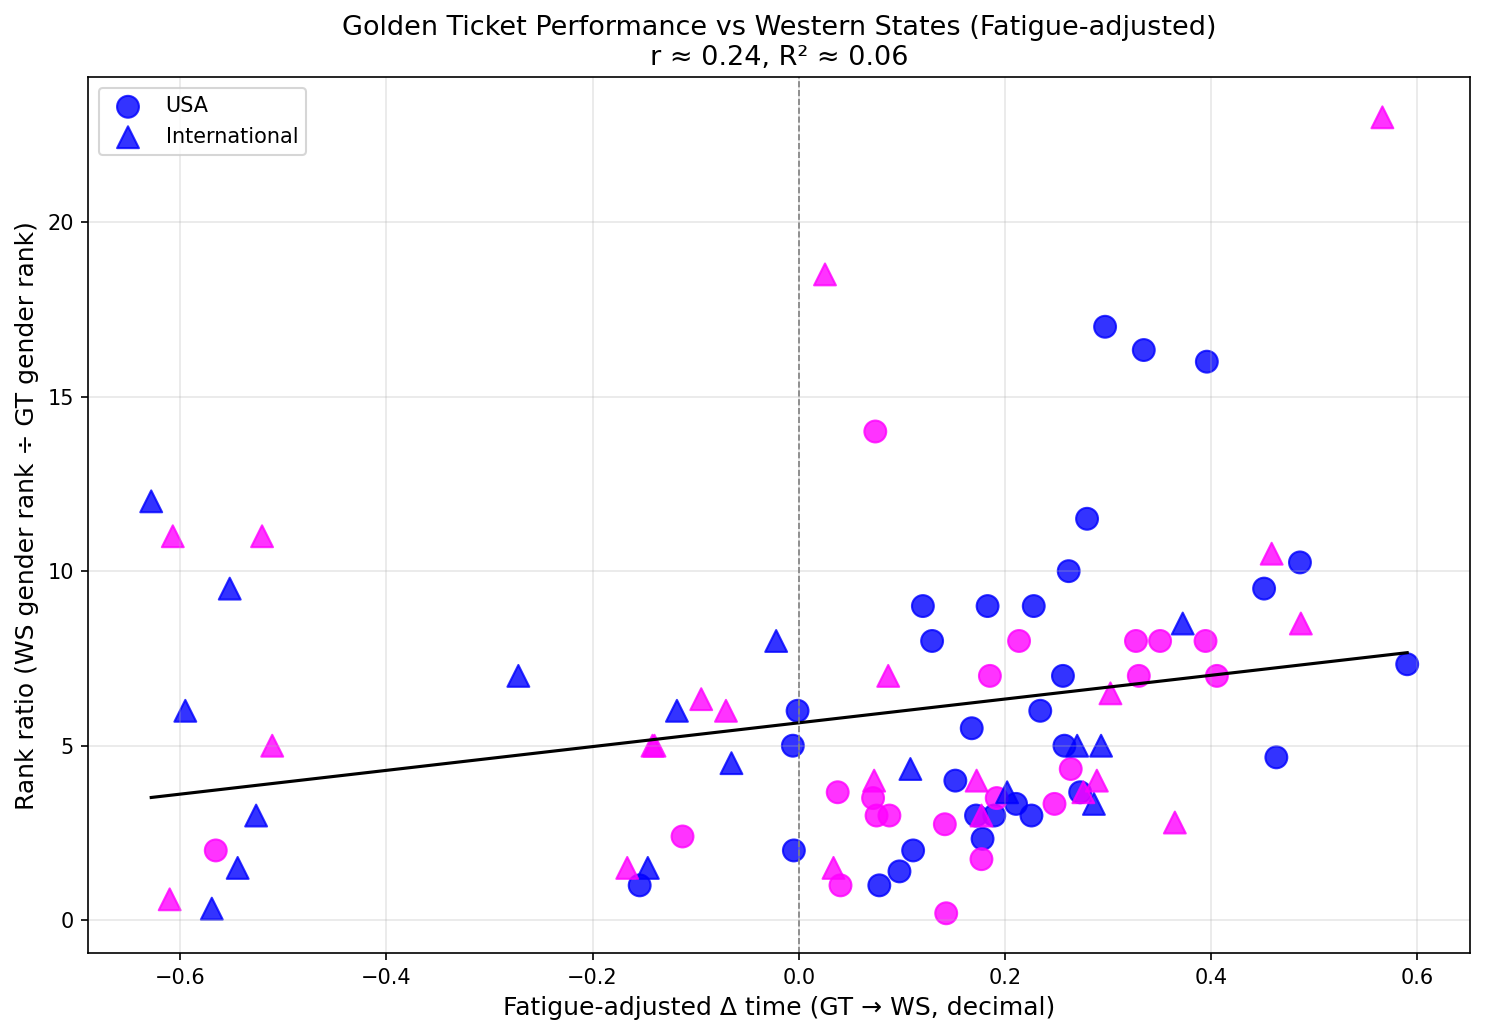

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 1. Load data
# -------------------------------------------------------------------
file_path = r"C:\Users\user\workspace\c11\Capstone\NewForce-Data-Analytics-Capstone\data\sql_backup_queries_csv\csv\gt_ws_perf_to_HA.csv"  # update path if needed
df = pd.read_csv(file_path)

# -------------------------------------------------------------------
# 2. Basic cleaning & helper functions
# -------------------------------------------------------------------
# Convert gender ranks to numeric
df["gt_gender_rank"] = pd.to_numeric(df["gt_gender_rank"], errors="coerce")
df["ws_gender_rank"] = pd.to_numeric(df["ws_gender_rank"], errors="coerce")

# Convert HH:MM:SS to total seconds
def to_seconds(t):
    try:
        h, m, s = str(t).split(":")
        return int(h) * 3600 + int(m) * 60 + int(float(s))
    except Exception:
        return np.nan

df["gt_sec"] = df["gt_time"].apply(to_seconds)
df["ws_sec"] = df["ws_time"].apply(to_seconds)

# -------------------------------------------------------------------
# 3. GT race distances (km) + WS distance
#    (these are the "corrected distances" we discussed)
# -------------------------------------------------------------------
distance_map = {
    "Nice Cote D Azur": 111.0,      # Nice Côte d’Azur 100k ~111 km
    "Nice Cote d Azur": 111.0,
    "Chianti (UTCC)": 103.0,        # UTCC ~103 km
    "The Canyons": 100.0,           # Canyons 100k
    "Black Canyon": 101.0,          # Black Canyon 100k ~101 km
    "Javelina": 159.2,              # Javelina Jundred 100M ~159.2 km
    "Grindstone": 100.0,            # Grindstone 100k
    "UTMB": 100.0,                  # 100k-class qualifier (approx)
    "CCC": 100.0,                   # CCC ~98–101 km
    "Tarawera": 102.0,              # Tarawera 102k
    "Bandera": 100.0,               # Bandera 100k
    "Doi Inthanon": 95.0,           # Doi Inthanon "100k" course ~95 km
    "Festival Des Templiers": 80.6  # Grand Trail des Templiers ~80.6 km
}

df["gt_distance_km"] = df["gt_race_name"].map(distance_map)
df["ws_distance_km"] = 160.9   # Western States 100M ≈ 160.9 km

# -------------------------------------------------------------------
# 4. Riegel model: predict WS time from GT performance
# -------------------------------------------------------------------
riegel_exponent = 1.06  # standard ultra exponent

df["ws_pred_sec"] = df["gt_sec"] * (
    (df["ws_distance_km"] / df["gt_distance_km"]) ** riegel_exponent
)

# -------------------------------------------------------------------
# 5. Build key metrics: fatigue-adjusted Δ and rank ratio
# -------------------------------------------------------------------
# Fatigue-adjusted delta (decimal):
#   0.0 = exactly as predicted
#   0.3 = 30% slower than predicted
df["delta_fatigue"] = (df["ws_sec"] - df["ws_pred_sec"]) / df["ws_pred_sec"]

# Rank ratio: how WS placement compares to GT placement
df["rank_ratio"] = df["ws_gender_rank"] / df["gt_gender_rank"]

# Drop rows with missing values in the metrics we care about
valid = df.dropna(subset=["delta_fatigue", "rank_ratio", "gt_gender", "nationality"])

# -------------------------------------------------------------------
# 6. Correlation (r) and R²
# -------------------------------------------------------------------
x = valid["delta_fatigue"].values
y = valid["rank_ratio"].values

r = np.corrcoef(x, y)[0, 1]
r_squared = r ** 2

print(f"Pearson r (delta_fatigue vs rank_ratio): {r:.3f}")
print(f"R² (variance explained): {r_squared:.3f} (~{r_squared*100:.1f}%)")

# -------------------------------------------------------------------
# 7. Scatter plot: fatigue-adjusted Δ vs rank ratio
#    - Blue = male, Pink = female
#    - Circle = USA, Triangle = international
# -------------------------------------------------------------------
def color_for_gender(g):
    return "blue" if g == "M" else "magenta"  # pink-ish

def marker_for_nat(n):
    return "o" if n == "USA" else "^"         # circle vs triangle

plt.figure(figsize=(10, 7), dpi=150)
ax = plt.gca()

for marker in ["o", "^"]:
    mask_shape = valid["nationality"].apply(marker_for_nat) == marker
    ax.scatter(
        valid.loc[mask_shape, "delta_fatigue"],
        valid.loc[mask_shape, "rank_ratio"],
        c=valid.loc[mask_shape, "gt_gender"].apply(color_for_gender),
        marker=marker,
        s=110,
        alpha=0.8,
        label="USA" if marker == "o" else "International"
    )

# Regression line
m, b = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 200)
y_line = m * x_line + b
ax.plot(x_line, y_line, color="black", linewidth=1.5)

# Axes labels & title
ax.set_xlabel("Fatigue-adjusted Δ time (GT → WS, decimal)", fontsize=12)
ax.set_ylabel("Rank ratio (WS gender rank ÷ GT gender rank)", fontsize=12)
ax.set_title(
    "Golden Ticket Performance vs Western States (Fatigue-adjusted)\n"
    f"r ≈ {r:.2f}, R² ≈ {r_squared:.2f}",
    fontsize=13
)

ax.axvline(0, color="gray", linestyle="--", linewidth=0.8)  # reference: predicted performance
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [2]:
r_diff = np.corrcoef(df["diff_index"], df["rank_ratio"])[0, 1]
print(f"Correlation (Difficulty Index vs Rank Ratio): {r_diff:.3f}")

Correlation (Difficulty Index vs Rank Ratio): nan


In [3]:
import statsmodels.api as sm

# Drop missing values
model_df = df.dropna(subset=["rank_ratio", "delta_fatigue", "diff_index"])
X = model_df[["delta_fatigue", "diff_index"]]
X = sm.add_constant(X)
y = model_df["rank_ratio"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             rank_ratio   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     9.805
Date:                Thu, 13 Nov 2025   Prob (F-statistic):           0.000143
Time:                        07:36:45   Log-Likelihood:                -251.54
No. Observations:                  91   AIC:                             509.1
Df Residuals:                      88   BIC:                             516.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.2282      1.275      0.963

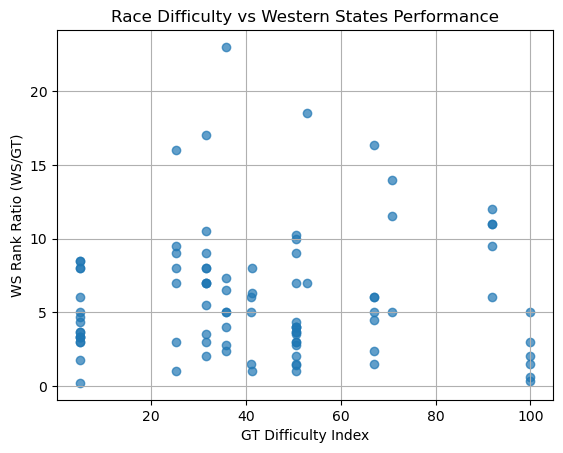

In [4]:
plt.scatter(df["diff_index"], df["rank_ratio"], alpha=0.7)
plt.xlabel("GT Difficulty Index")
plt.ylabel("WS Rank Ratio (WS/GT)")
plt.title("Race Difficulty vs Western States Performance")
plt.grid(True)
plt.show()

Pearson r = 0.237  (R² ≈ 0.056 → 5.6% variance explained)
                            OLS Regression Results                            
Dep. Variable:             rank_ratio   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     9.805
Date:                Thu, 13 Nov 2025   Prob (F-statistic):           0.000143
Time:                        07:39:20   Log-Likelihood:                -251.54
No. Observations:                  91   AIC:                             509.1
Df Residuals:                      88   BIC:                             516.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

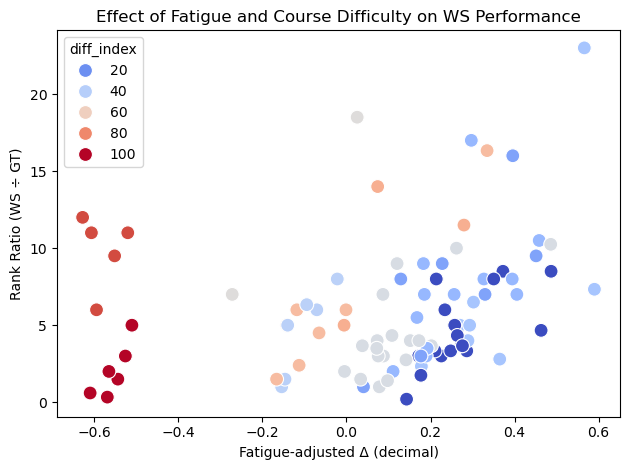

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ---------------------------------------------------------------
# 1. Load and clean dataset
# ---------------------------------------------------------------
file_path = r"C:\Users\user\workspace\c11\Capstone\NewForce-Data-Analytics-Capstone\data\sql_backup_queries_csv\csv\gt_ws_perf_to_HA.csv"  # update path if needed
df = pd.read_csv(file_path)


# Convert rank columns
df["gt_gender_rank"] = pd.to_numeric(df["gt_gender_rank"], errors="coerce")
df["ws_gender_rank"] = pd.to_numeric(df["ws_gender_rank"], errors="coerce")

# Convert HH:MM:SS to total seconds
def to_sec(t):
    try:
        h, m, s = str(t).split(":")
        return int(h)*3600 + int(m)*60 + int(float(s))
    except Exception:
        return np.nan

df["gt_sec"] = df["gt_time"].apply(to_sec)
df["ws_sec"] = df["ws_time"].apply(to_sec)

# ---------------------------------------------------------------
# 2. Accurate GT distances (km)
# ---------------------------------------------------------------
distance_map = {
    "Nice Cote D Azur": 111.0,
    "Nice Cote d Azur": 111.0,
    "Chianti (UTCC)": 103.0,
    "The Canyons": 100.0,
    "Black Canyon": 101.0,
    "Javelina": 159.2,
    "Grindstone": 100.0,
    "UTMB": 100.0,
    "CCC": 100.0,
    "Tarawera": 102.0,
    "Bandera": 100.0,
    "Doi Inthanon": 95.0,
    "Festival Des Templiers": 80.6
}
df["gt_distance_km"] = df["gt_race_name"].map(distance_map)
df["ws_distance_km"] = 160.9  # WS 100 mi

# ---------------------------------------------------------------
# 3. Fatigue-adjusted delta and rank ratio
# ---------------------------------------------------------------
riegel = 1.06
df["ws_pred_sec"] = df["gt_sec"] * ((df["ws_distance_km"] / df["gt_distance_km"]) ** riegel)
df["delta_fatigue"] = (df["ws_sec"] - df["ws_pred_sec"]) / df["ws_pred_sec"]
df["rank_ratio"] = df["ws_gender_rank"] / df["gt_gender_rank"]

# Keep usable rows
valid = df.dropna(subset=["delta_fatigue", "rank_ratio", "diff_index", "gt_gender", "nationality"])

# ---------------------------------------------------------------
# 4. Correlation (simple)
# ---------------------------------------------------------------
r = np.corrcoef(valid["delta_fatigue"], valid["rank_ratio"])[0, 1]
r2 = r**2
print(f"Pearson r = {r:.3f}  (R² ≈ {r2:.3f} → {r2*100:.1f}% variance explained)")

# ---------------------------------------------------------------
# 5. Multivariate model adding Difficulty Index
# ---------------------------------------------------------------
X = valid[["delta_fatigue", "diff_index"]]
X = sm.add_constant(X)
y = valid["rank_ratio"]

model = sm.OLS(y, X).fit()
print(model.summary())

# ---------------------------------------------------------------
# 6. Scatter plot: Difficulty Index vs WS rank ratio
# ---------------------------------------------------------------
# plt.figure(figsize=(8,6), dpi=150)
# plt.scatter(valid["diff_index"], valid["rank_ratio"], alpha=0.8, color="teal")
# m, b = np.polyfit(valid["diff_index"], valid["rank_ratio"], 1)
# xx = np.linspace(valid["diff_index"].min(), valid["diff_index"].max(), 100)
# plt.plot(xx, m*xx + b, color="black", linewidth=1.3)

# plt.xlabel("GT Difficulty Index")
# plt.ylabel("Rank Ratio (WS ÷ GT)")
# plt.title("Golden Ticket Race Difficulty vs Western States Performance")
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()

# ---------------------------------------------------------------
# 7. Optional: combined 3-D surface or color-coded scatter
# ---------------------------------------------------------------
# Uncomment to visualize both predictors together
import seaborn as sns
sns.scatterplot(
    data=valid,
    x="delta_fatigue",
    y="rank_ratio",
    hue="diff_index",
    palette="coolwarm",
    s=100
).set(
    title="Effect of Fatigue and Course Difficulty on WS Performance",
    xlabel="Fatigue-adjusted Δ (decimal)",
    ylabel="Rank Ratio (WS ÷ GT)"
)
plt.tight_layout()
plt.show()

Pearson r (delta_fatigue vs rank_ratio): 0.300
R² (variance explained): 0.090 (~9.0%)


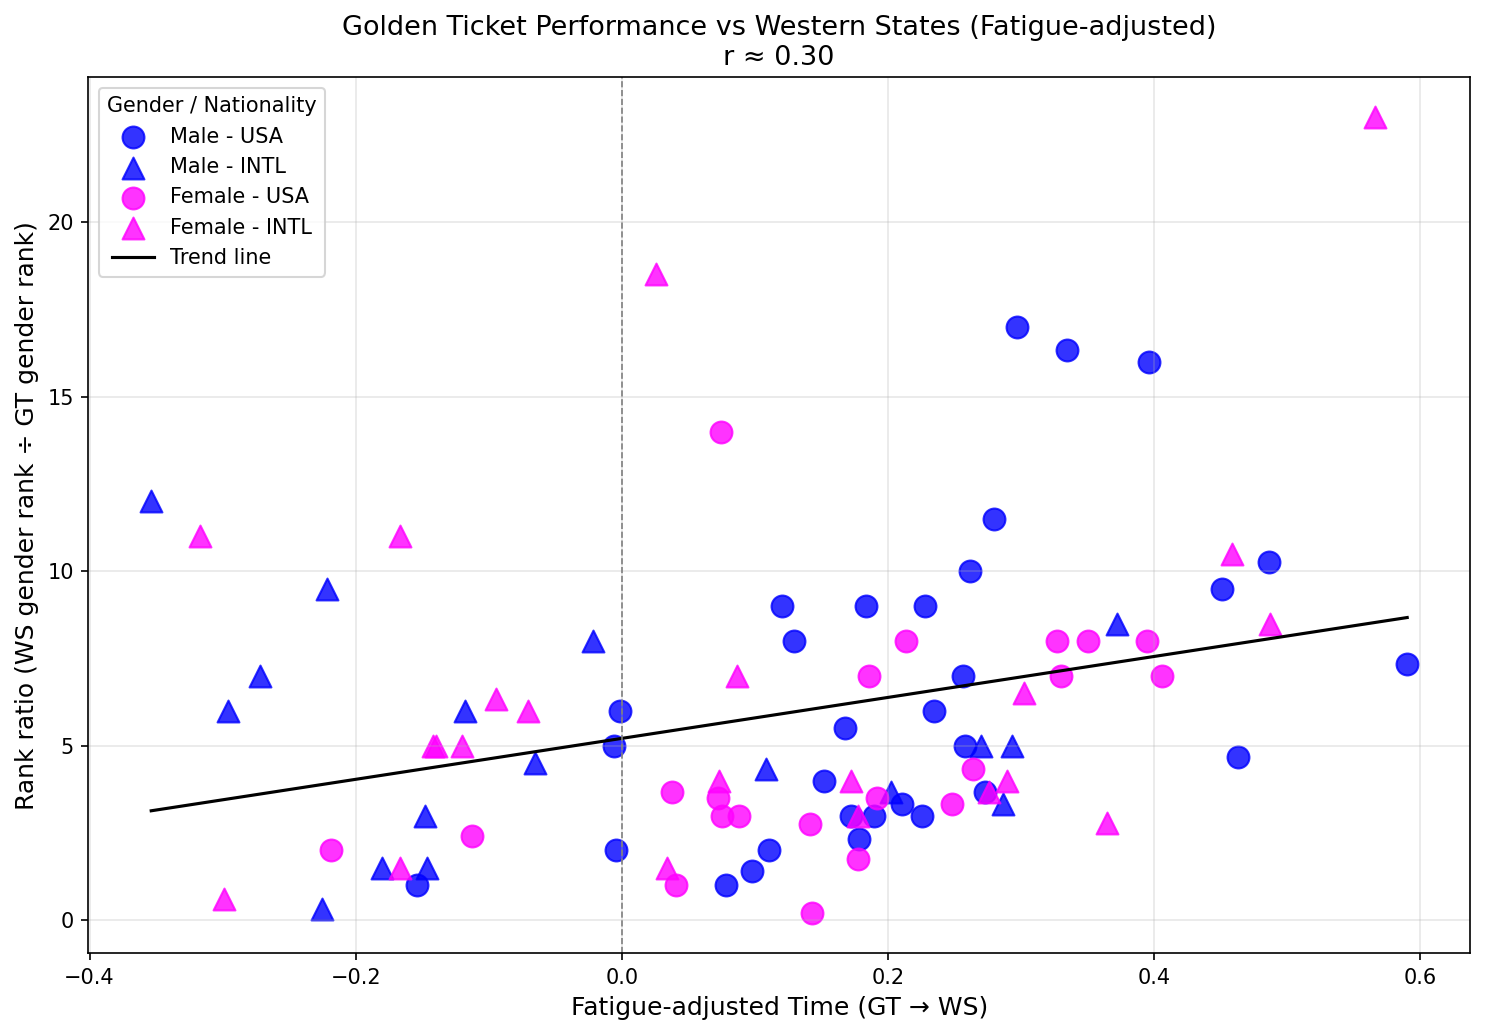

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# -------------------------------------------------------------------
# 1. Load data
# -------------------------------------------------------------------
file_path = r"C:\Users\user\workspace\c11\Capstone\NewForce-Data-Analytics-Capstone\data\sql_backup_queries_csv\csv\gt_ws_perf_to_HA.csv"
df = pd.read_csv(file_path)

# -------------------------------------------------------------------
# 2. Basic cleaning & helper functions
# -------------------------------------------------------------------
df["gt_gender_rank"] = pd.to_numeric(df["gt_gender_rank"], errors="coerce")
df["ws_gender_rank"] = pd.to_numeric(df["ws_gender_rank"], errors="coerce")

def to_seconds(t):
    try:
        h, m, s = str(t).split(":")
        return int(h) * 3600 + int(m) * 60 + int(float(s))
    except Exception:
        return np.nan

df["gt_sec"] = df["gt_time"].apply(to_seconds)
df["ws_sec"] = df["ws_time"].apply(to_seconds)

# -------------------------------------------------------------------
# 3. GT race distances (km) + WS distance
# -------------------------------------------------------------------
distance_map = {
    "Nice Cote d Azur": 111.0,
    "Chianti (UTCC)": 103.0,
    "The Canyons": 100.0,
    "Black Canyon": 101.0,
    "Javelina": 159.2,
    "Grindstone": 100.0,
    "UTMB": 174.0,
    "CCC": 100.0,
    "Tarawera": 102.0,
    "Bandera": 100.0,
    "Doi Inthanon": 160.0,
    "Festival Des Templiers": 80.6
}
df["gt_distance_km"] = df["gt_race_name"].map(distance_map)
df["ws_distance_km"] = 160.9

# -------------------------------------------------------------------
# 4. Riegel model: predict WS time from GT performance
# -------------------------------------------------------------------
riegel_exponent = 1.06
df["ws_pred_sec"] = df["gt_sec"] * ((df["ws_distance_km"] / df["gt_distance_km"]) ** riegel_exponent)

# -------------------------------------------------------------------
# 5. Build key metrics: fatigue-adjusted Δ and rank ratio
# -------------------------------------------------------------------
df["delta_fatigue"] = (df["ws_sec"] - df["ws_pred_sec"]) / df["ws_pred_sec"]
df["rank_ratio"] = df["ws_gender_rank"] / df["gt_gender_rank"]

valid = df.dropna(subset=["delta_fatigue", "rank_ratio", "gt_gender", "nationality"])

# -------------------------------------------------------------------
# 6. Correlation (r) and R²
# -------------------------------------------------------------------
x = valid["delta_fatigue"].values
y = valid["rank_ratio"].values
r = np.corrcoef(x, y)[0, 1]
r_squared = r ** 2
print(f"Pearson r (delta_fatigue vs rank_ratio): {r:.3f}")
print(f"R² (variance explained): {r_squared:.3f} (~{r_squared*100:.1f}%)")

# -------------------------------------------------------------------
# 7. Scatter plot: fatigue-adjusted Δ vs rank ratio (gender + nationality)
# -------------------------------------------------------------------
plt.figure(figsize=(10, 7), dpi=150)
ax = plt.gca()

# Separate data by gender and nationality for custom legend
for gender, color in [("M", "blue"), ("F", "magenta")]:
    for nat, marker in [("USA", "o"), ("INTL", "^")]:
        mask = (valid["gt_gender"] == gender) & (
            (valid["nationality"] == "USA") if nat == "USA" else (valid["nationality"] != "USA")
        )
        if mask.sum() > 0:
            ax.scatter(
                valid.loc[mask, "delta_fatigue"],
                valid.loc[mask, "rank_ratio"],
                c=color,
                marker=marker,
                s=110,
                alpha=0.8,
                label=f"{'Male' if gender=='M' else 'Female'} - {nat}"
            )

# Regression line
m, b = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 200)
y_line = m * x_line + b
ax.plot(x_line, y_line, color="black", linewidth=1.5, label="Trend line")

# Axes labels & title
ax.set_xlabel("Fatigue-adjusted Time (GT → WS)", fontsize=12)
ax.set_ylabel("Rank ratio (WS gender rank ÷ GT gender rank)", fontsize=12)
ax.set_title(
    f"Golden Ticket Performance vs Western States (Fatigue-adjusted)\n"
    f"r ≈ {r:.2f}",
    fontsize=13
)
ax.axvline(0, color="gray", linestyle="--", linewidth=0.8)
ax.grid(alpha=0.3)
ax.legend(title="Gender / Nationality", loc="upper left", frameon=True)
plt.tight_layout()

plt.savefig('../python_images/rank_ratio_reagal_model.png', dpi = 300)

plt.show()




Correlation (Difficulty Index vs WS Rank Ratio): 0.032
                            OLS Regression Results                            
Dep. Variable:             rank_ratio   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     9.805
Date:                Thu, 13 Nov 2025   Prob (F-statistic):           0.000143
Time:                        08:24:36   Log-Likelihood:                -251.54
No. Observations:                  91   AIC:                             509.1
Df Residuals:                      88   BIC:                             516.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

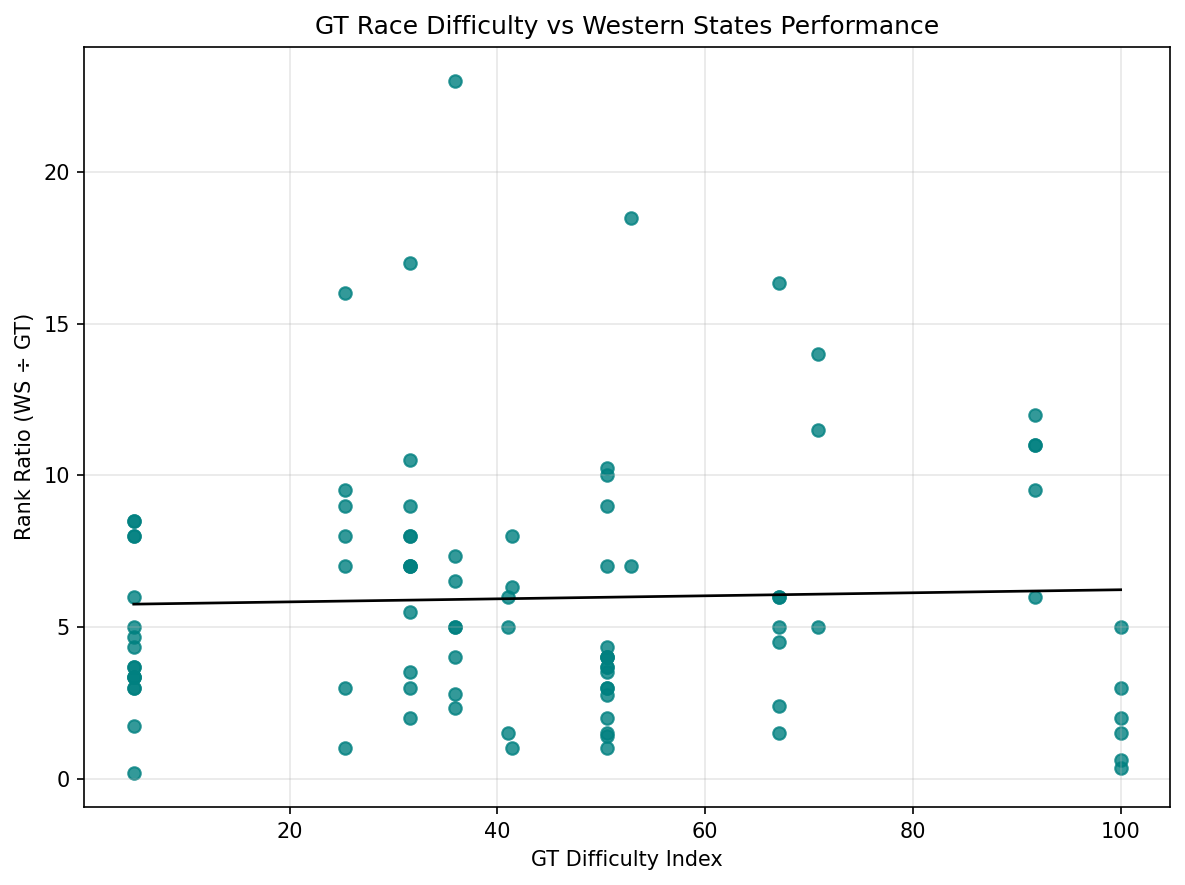

In [19]:
# -------------------------------------------------------------------
# 8. Add Difficulty Index Analysis
# -------------------------------------------------------------------
if "diff_index" in df.columns:
    model_df = valid.dropna(subset=["diff_index"])

    # Correlation between difficulty and WS performance
    r_diff = np.corrcoef(model_df["diff_index"], model_df["rank_ratio"])[0, 1]
    print(f"\nCorrelation (Difficulty Index vs WS Rank Ratio): {r_diff:.3f}")

    # Multivariate regression
    X = model_df[["delta_fatigue", "diff_index"]]
    X = sm.add_constant(X)
    y = model_df["rank_ratio"]
    model = sm.OLS(y, X).fit()
    print(model.summary())

    # Scatter: Difficulty vs WS rank ratio
    plt.figure(figsize=(8,6), dpi=150)
    plt.scatter(model_df["diff_index"], model_df["rank_ratio"], color="teal", alpha=0.8)
    m2, b2 = np.polyfit(model_df["diff_index"], model_df["rank_ratio"], 1)
    xx = np.linspace(model_df["diff_index"].min(), model_df["diff_index"].max(), 100)
    plt.plot(xx, m2*xx + b2, color="black", linewidth=1.3)
    plt.xlabel("GT Difficulty Index")
    plt.ylabel("Rank Ratio (WS ÷ GT)")
    plt.title("GT Race Difficulty vs Western States Performance")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    # plt.savefig("python_images/rank_ratio_reagal_model.png", dpi=300, bbox_inches="tight")
    plt.show()
else:
    print("\n⚠️ 'diff_index' column not found in this dataset. Please confirm its name or spelling.")

                            OLS Regression Results                            
Dep. Variable:             rank_ratio   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     11.68
Date:                Thu, 13 Nov 2025   Prob (F-statistic):           3.18e-05
Time:                        12:25:22   Log-Likelihood:                -249.99
No. Observations:                  91   AIC:                             506.0
Df Residuals:                      88   BIC:                             513.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0588      1.227      0.863

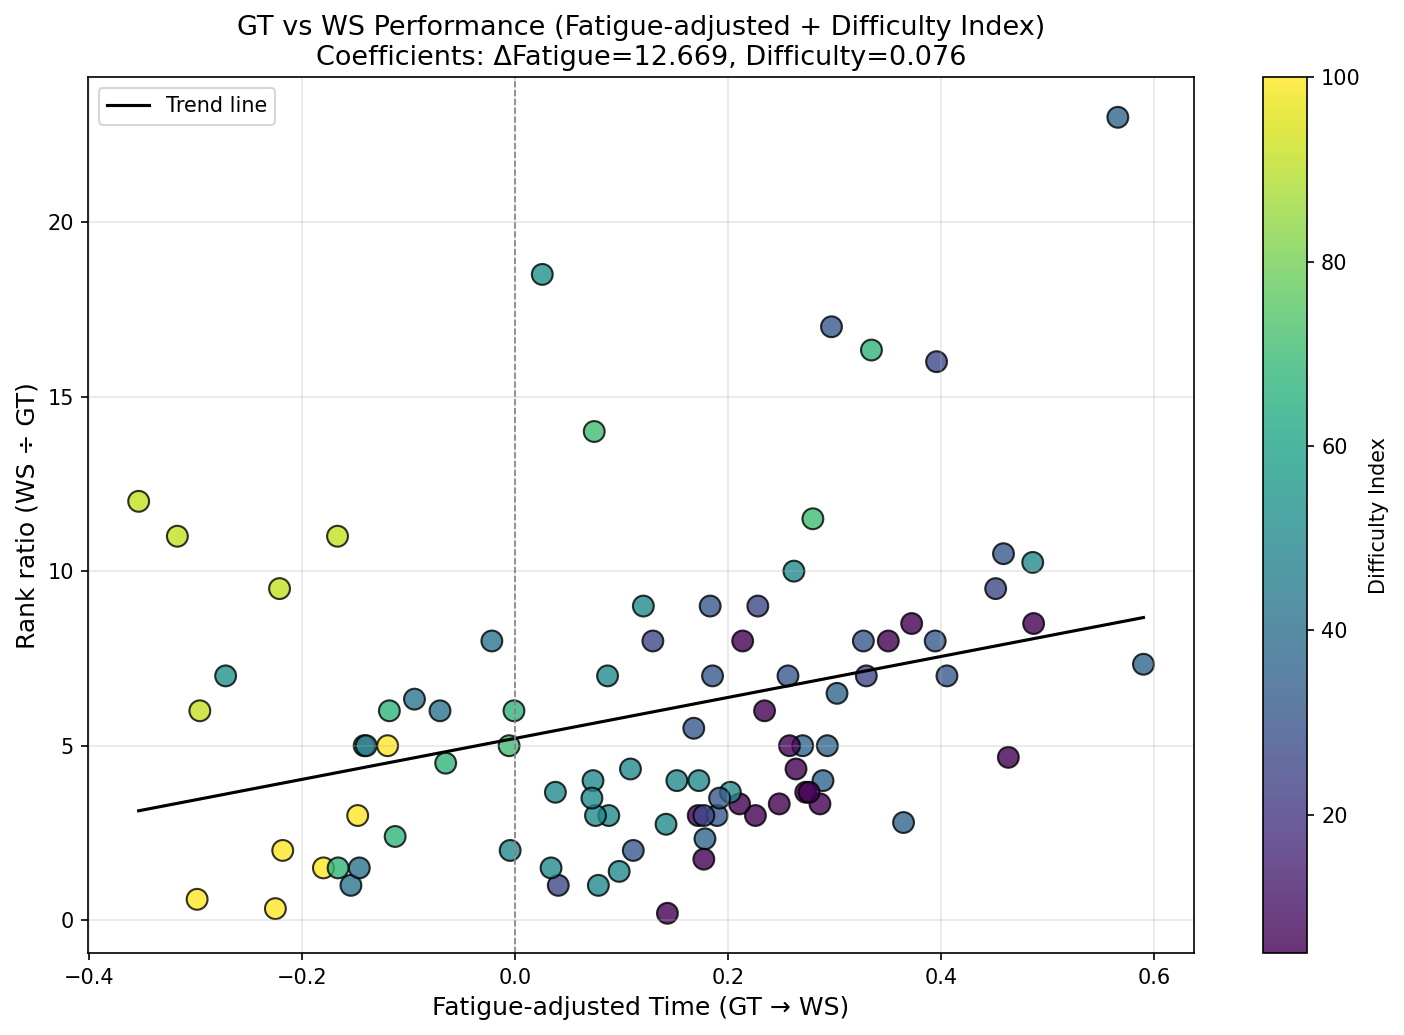

In [27]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# -------------------------------------------------------------------
# 1. Load data
# -------------------------------------------------------------------
file_path = r"C:\Users\user\workspace\c11\Capstone\NewForce-Data-Analytics-Capstone\data\sql_backup_queries_csv\csv\gt_ws_perf_to_HA.csv"
df = pd.read_csv(file_path)

# -------------------------------------------------------------------
# 2. Basic cleaning & helper functions
# -------------------------------------------------------------------
df["gt_gender_rank"] = pd.to_numeric(df["gt_gender_rank"], errors="coerce")
df["ws_gender_rank"] = pd.to_numeric(df["ws_gender_rank"], errors="coerce")

def to_seconds(t):
    try:
        h, m, s = str(t).split(":")
        return int(h) * 3600 + int(m) * 60 + int(float(s))
    except Exception:
        return np.nan

df["gt_sec"] = df["gt_time"].apply(to_seconds)
df["ws_sec"] = df["ws_time"].apply(to_seconds)

# -------------------------------------------------------------------
# 3. GT race distances (km) + WS distance
# -------------------------------------------------------------------
distance_map = {
    "Nice Cote d Azur": 111.0,
    "Chianti (UTCC)": 103.0,
    "The Canyons": 100.0,
    "Black Canyon": 101.0,
    "Javelina": 159.2,
    "Grindstone": 100.0,
    "UTMB": 174.0,
    "CCC": 100.0,
    "Tarawera": 102.0,
    "Bandera": 100.0,
    "Doi Inthanon": 160.0,
    "Festival Des Templiers": 80.6
}
df["gt_distance_km"] = df["gt_race_name"].map(distance_map)
df["ws_distance_km"] = 160.9

# -------------------------------------------------------------------
# 4. Riegel model: predict WS time from GT performance
# -------------------------------------------------------------------
riegel_exponent = 1.06
df["ws_pred_sec"] = df["gt_sec"] * ((df["ws_distance_km"] / df["gt_distance_km"]) ** riegel_exponent)

# -------------------------------------------------------------------
# 5. Build key metrics: fatigue-adjusted Δ and rank ratio
# -------------------------------------------------------------------
df["delta_fatigue"] = (df["ws_sec"] - df["ws_pred_sec"]) / df["ws_pred_sec"]
df["rank_ratio"] = df["ws_gender_rank"] / df["gt_gender_rank"]

valid = df.dropna(subset=["delta_fatigue", "rank_ratio", "gt_gender", "nationality", "diff_index"])

# -------------------------------------------------------------------
# 6. Regression with difficulty index
# -------------------------------------------------------------------
X = valid[["delta_fatigue", "diff_index"]]
X = sm.add_constant(X)
y = valid["rank_ratio"]
model = sm.OLS(y, X).fit()

print(model.summary())

# -------------------------------------------------------------------
# 7. Scatter plot: fatigue-adjusted Δ vs rank ratio, color by difficulty index
# -------------------------------------------------------------------
plt.figure(figsize=(10, 7), dpi=150)
scatter = plt.scatter(
    valid["delta_fatigue"],
    valid["rank_ratio"],
    c=valid["diff_index"],
    cmap="viridis",
    s=100,
    alpha=0.8,
    edgecolor="k"
)

# Regression line (based on delta_fatigue only for visualization)
m, b = np.polyfit(valid["delta_fatigue"], valid["rank_ratio"], 1)
x_line = np.linspace(valid["delta_fatigue"].min(), valid["delta_fatigue"].max(), 200)
y_line = m * x_line + b
plt.plot(x_line, y_line, color="black", linewidth=1.5, label="Trend line")

plt.colorbar(scatter, label="Difficulty Index")
plt.xlabel("Fatigue-adjusted Time (GT → WS)", fontsize=12)
plt.ylabel("Rank ratio (WS ÷ GT)", fontsize=12)
plt.title(
    f"GT vs WS Performance (Fatigue-adjusted + Difficulty Index)\n"
    f"Coefficients: ΔFatigue={model.params['delta_fatigue']:.3f}, Difficulty={model.params['diff_index']:.3f}",
    fontsize=13
)
plt.axvline(0, color="gray", linestyle="--", linewidth=0.8)
plt.grid(alpha=0.3)
plt.legend(loc="upper left")
plt.tight_layout()

# plt.savefig("updated_rank_ratio_with_difficulty.png", dpi=300)
plt.show()


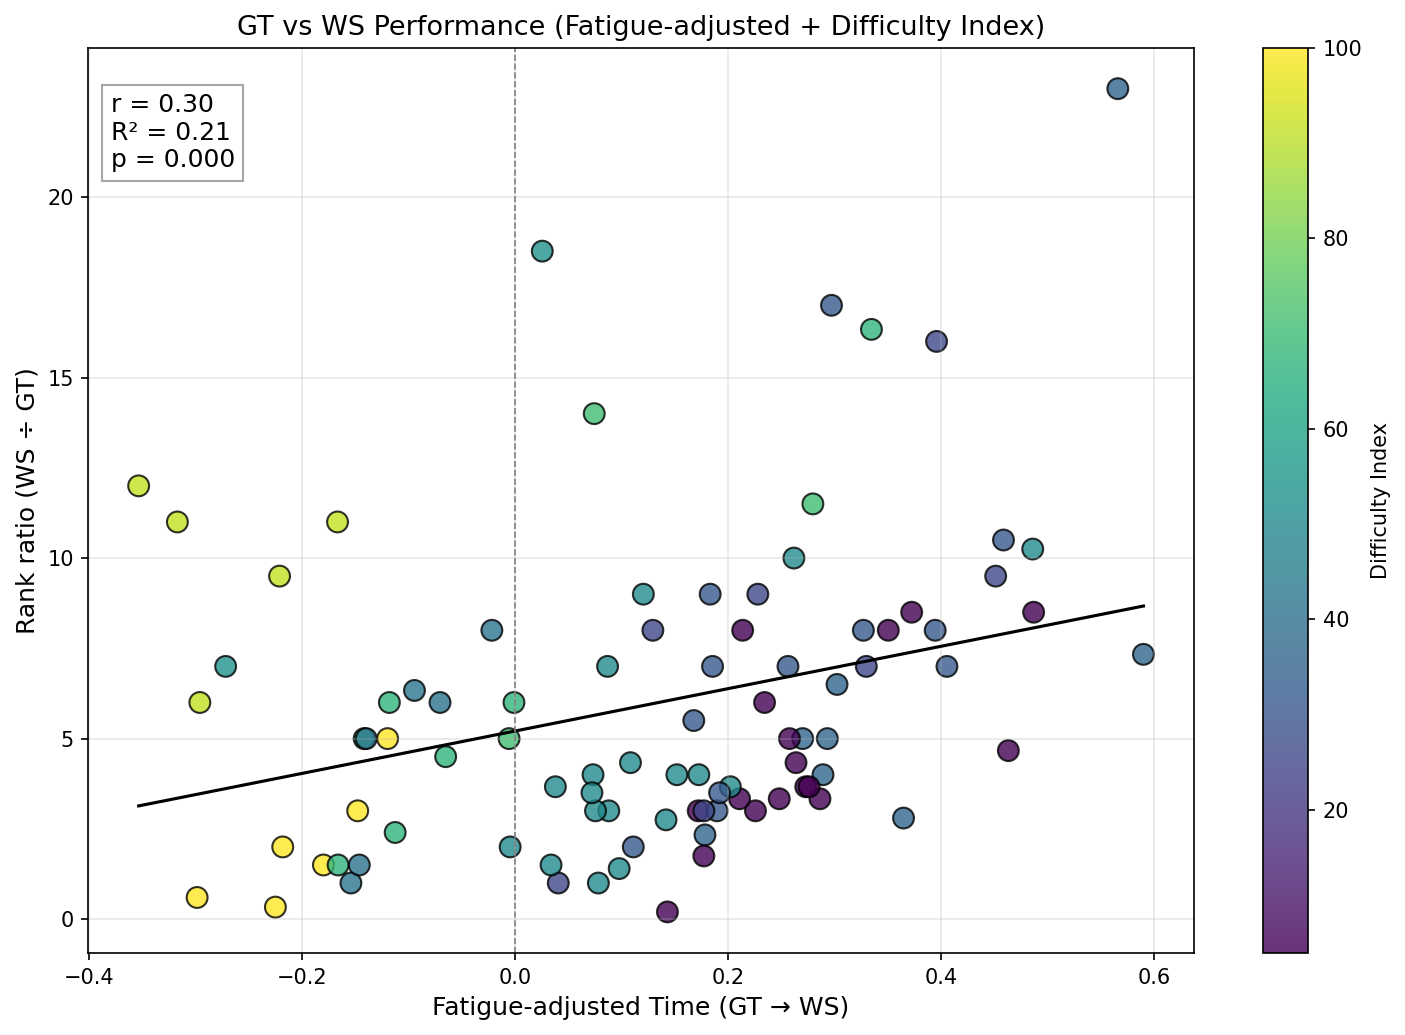

Pearson r: 0.300, R²: 0.210, p-value: 0.000


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# -------------------------------------------------------------------
# 1. Load data
# -------------------------------------------------------------------
file_path = r"C:\Users\user\workspace\c11\Capstone\NewForce-Data-Analytics-Capstone\data\sql_backup_queries_csv\csv\gt_ws_perf_to_HA.csv"
df = pd.read_csv(file_path)

# -------------------------------------------------------------------
# 2. Basic cleaning & helper functions
# -------------------------------------------------------------------
df["gt_gender_rank"] = pd.to_numeric(df["gt_gender_rank"], errors="coerce")
df["ws_gender_rank"] = pd.to_numeric(df["ws_gender_rank"], errors="coerce")

def to_seconds(t):
    try:
        h, m, s = str(t).split(":")
        return int(h) * 3600 + int(m) * 60 + int(float(s))
    except Exception:
        return np.nan

df["gt_sec"] = df["gt_time"].apply(to_seconds)
df["ws_sec"] = df["ws_time"].apply(to_seconds)

# -------------------------------------------------------------------
# 3. GT race distances (km) + WS distance
# -------------------------------------------------------------------
distance_map = {
    "Nice Cote d Azur": 111.0,
    "Chianti (UTCC)": 103.0,
    "The Canyons": 100.0,
    "Black Canyon": 101.0,
    "Javelina": 159.2,
    "Grindstone": 100.0,
    "UTMB": 174.0,
    "CCC": 100.0,
    "Tarawera": 102.0,
    "Bandera": 100.0,
    "Doi Inthanon": 160.0,
    "Festival Des Templiers": 80.6
}
df["gt_distance_km"] = df["gt_race_name"].map(distance_map)
df["ws_distance_km"] = 160.9

# -------------------------------------------------------------------
# 4. Riegel model: predict WS time from GT performance
# -------------------------------------------------------------------
riegel_exponent = 1.06
df["ws_pred_sec"] = df["gt_sec"] * ((df["ws_distance_km"] / df["gt_distance_km"]) ** riegel_exponent)

# -------------------------------------------------------------------
# 5. Build key metrics: fatigue-adjusted Δ and rank ratio
# -------------------------------------------------------------------
df["delta_fatigue"] = (df["ws_sec"] - df["ws_pred_sec"]) / df["ws_pred_sec"]
df["rank_ratio"] = df["ws_gender_rank"] / df["gt_gender_rank"]

valid = df.dropna(subset=["delta_fatigue", "rank_ratio", "gt_gender", "nationality", "diff_index"])

# -------------------------------------------------------------------
# 6. Regression with difficulty index
# -------------------------------------------------------------------
X = valid[["delta_fatigue", "diff_index"]]
X = sm.add_constant(X)
y = valid["rank_ratio"]
model = sm.OLS(y, X).fit()

# Compute Pearson r for delta_fatigue vs rank_ratio
r = np.corrcoef(valid["delta_fatigue"], valid["rank_ratio"])[0, 1]
r_squared = model.rsquared
p_value = model.f_pvalue

# Format p-value as 0.000 if very small
p_display = f"{p_value:.3f}" if p_value >= 0.001 else "0.000"

# -------------------------------------------------------------------
# 7. Scatter plot: fatigue-adjusted Δ vs rank ratio, color by difficulty index
# -------------------------------------------------------------------
plt.figure(figsize=(10, 7), dpi=150)
scatter = plt.scatter(
    valid["delta_fatigue"],
    valid["rank_ratio"],
    c=valid["diff_index"],
    cmap="viridis",
    s=100,
    alpha=0.8,
    edgecolor="k"
)

# Regression line (based on delta_fatigue only for visualization)
m, b = np.polyfit(valid["delta_fatigue"], valid["rank_ratio"], 1)
x_line = np.linspace(valid["delta_fatigue"].min(), valid["delta_fatigue"].max(), 200)
y_line = m * x_line + b
plt.plot(x_line, y_line, color="black", linewidth=1.5)

plt.colorbar(scatter, label="Difficulty Index")
plt.xlabel("Fatigue-adjusted Time (GT → WS)", fontsize=12)
plt.ylabel("Rank ratio (WS ÷ GT)", fontsize=12)
plt.title("GT vs WS Performance (Fatigue-adjusted + Difficulty Index)", fontsize=13)
plt.axvline(0, color="gray", linestyle="--", linewidth=0.8)
plt.grid(alpha=0.3)

# Replace legend with text annotation for r, R², and p-value
stats_text = f"r = {r:.2f}\nR² = {r_squared:.2f}\np = {p_display}"
plt.text(0.02, 0.95, stats_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.tight_layout()
plt.savefig("../python_images/gt_vs_ws_performance_fatigue_diff.png", dpi=300)
plt.show()

print(f"Pearson r: {r:.3f}, R²: {r_squared:.3f}, p-value: {p_display}")


M: k = 1.169 (β_diff = -0.0049, R² = 0.83)
F: k = 0.934 (β_diff = -0.0062, R² = 0.86)
M: k=1.169, beta_diff=-0.0049, alpha=0.2776, R^2=0.83
F: k=0.934, beta_diff=-0.0062, alpha=0.4026, R^2=0.86


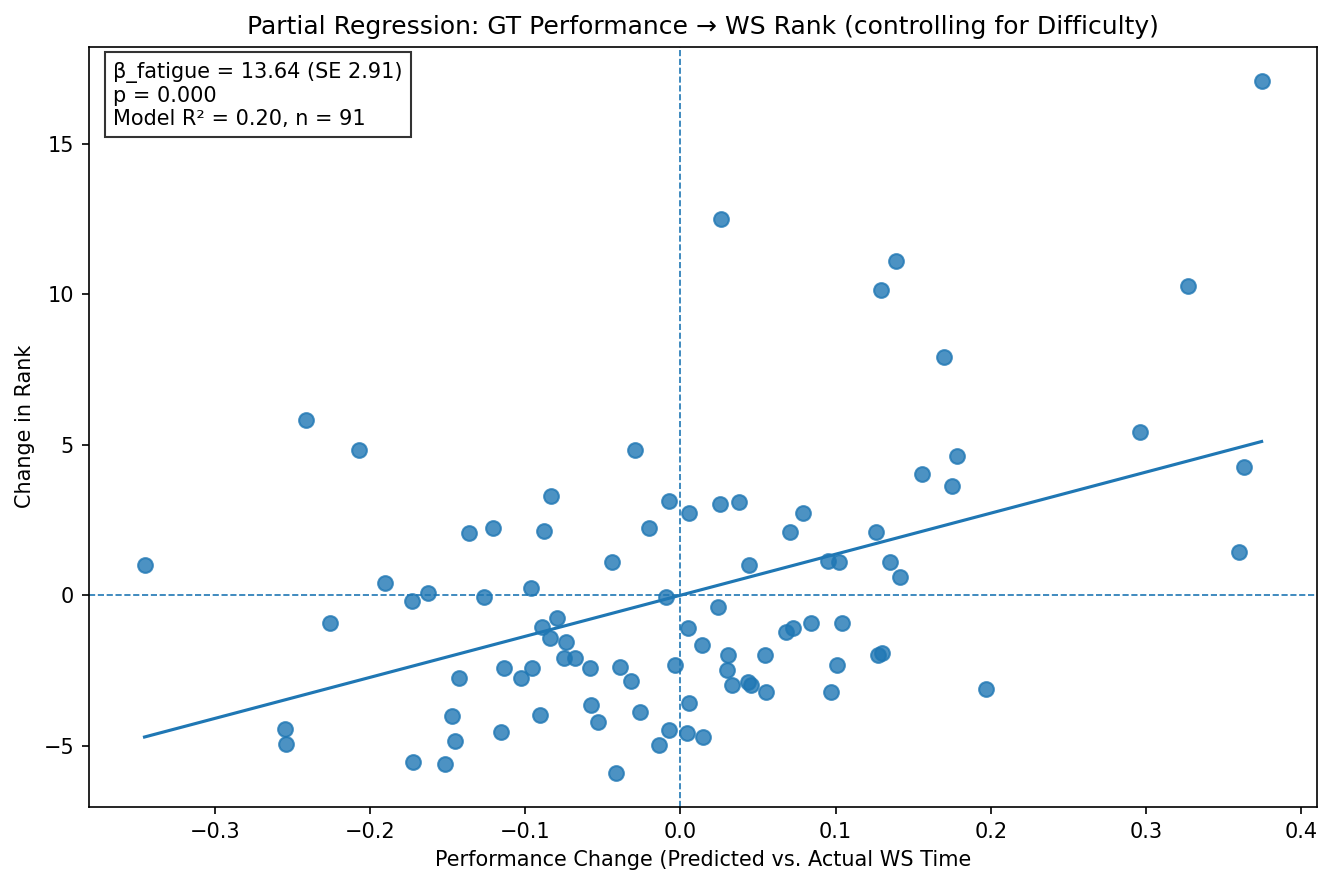

,coef,std_err,t,p>|t|
const,5.6236,0.7584,7.4154,0.0000
delta_fatigue,13.6435,2.9064,4.6942,0.0000
diff_index,0.0044,0.0148,0.2962,0.7678


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# -------------------------------------------------------------------
# 1) Load the new uploaded CSV dataset
# -------------------------------------------------------------------
file_path = r"C:\Users\user\workspace\c11\Capstone\NewForce-Data-Analytics-Capstone\data\sql_backup_queries_csv\csv\gt_ws_perf_to_HA.csv"
df = pd.read_csv(file_path)


# -------------------------------------------------------------------
# 2) Clean and create time-in-seconds
# -------------------------------------------------------------------
df["gt_gender_rank"] = pd.to_numeric(df["gt_gender_rank"], errors="coerce")
df["ws_gender_rank"] = pd.to_numeric(df["ws_gender_rank"], errors="coerce")

def to_seconds(t):
    try:
        h, m, s = str(t).split(":")
        return int(h) * 3600 + int(m) * 60 + int(float(s))
    except Exception:
        return np.nan

df["gt_sec"] = df["gt_time"].apply(to_seconds)
df["ws_sec"] = df["ws_time"].apply(to_seconds)

# -------------------------------------------------------------------
# 3) Distances (km) map for GT races + WS distance
# -------------------------------------------------------------------
distance_map = {
    "Nice Cote d Azur": 111.0,
    "Chianti (UTCC)": 103.0,
    "The Canyons": 100.0,
    "Black Canyon": 101.0,
    "Javelina": 159.2,
    "Grindstone": 100.0,
    "UTMB": 174.0,
    "CCC": 100.0,
    "Tarawera": 102.0,
    "Bandera": 100.0,
    "Doi Inthanon": 160.0,
    "Festival Des Templiers": 80.6
}
df["gt_distance_km"] = df["gt_race_name"].map(distance_map)
df["ws_distance_km"] = 160.9
df = df.dropna(subset=["gt_distance_km"])

# -------------------------------------------------------------------
# 4) Estimate gender-specific Riegel exponents (k) controlling for difficulty
# -------------------------------------------------------------------
k_by_gender = {}
for g in ['M','F']:
    sub = df[df['gt_gender']==g].dropna(subset=['gt_sec','ws_sec','gt_distance_km','diff_index'])
    sub['log_ratio'] = np.log(sub['ws_sec']/sub['gt_sec'])
    sub['log_dist_ratio'] = np.log(160.9/sub['gt_distance_km'])
    X = sm.add_constant(sub[['log_dist_ratio','diff_index']])
    y = sub['log_ratio']
    res = sm.OLS(y, X).fit()
    k_by_gender[g] = res.params['log_dist_ratio']
    print(f"{g}: k = {k_by_gender[g]:.3f} (β_diff = {res.params['diff_index']:.4f}, R² = {res.rsquared:.2f})")

# After Step 4: store full params (const, k, beta_diff) per gender
params_by_gender = {}
for g in ['M','F']:
    sub = df[df['gt_gender']==g].dropna(subset=['gt_sec','ws_sec','gt_distance_km','diff_index'])
    sub['log_ratio'] = np.log(sub['ws_sec']/sub['gt_sec'])
    sub['log_dist_ratio'] = np.log(160.9/sub['gt_distance_km'])
    X = sm.add_constant(sub[['log_dist_ratio','diff_index']])
    y = sub['log_ratio']
    res = sm.OLS(y, X).fit()
    params_by_gender[g] = {
        'alpha': res.params['const'],
        'k': res.params['log_dist_ratio'],
        'beta_diff': res.params['diff_index']
    }
    print(f"{g}: k={res.params['log_dist_ratio']:.3f}, beta_diff={res.params['diff_index']:.4f}, alpha={res.params['const']:.4f}, R^2={res.rsquared:.2f}")

# Replace the prediction to include difficulty

def predict_ws_time_diffadj(row):
    p = params_by_gender.get(row['gt_gender'])
    if p is None or pd.isna(row['gt_distance_km']) or pd.isna(row['diff_index']) or pd.isna(row['gt_sec']):
        return np.nan
    log_dist = np.log(row['ws_distance_km'] / row['gt_distance_km'])
    log_ratio = p['alpha'] + p['k']*log_dist + p['beta_diff']*row['diff_index']
    ratio = np.exp(log_ratio)
    return row['gt_sec'] * ratio

df['ws_pred_sec'] = df.apply(predict_ws_time_diffadj, axis=1)  # now difficulty-adjusted
df['delta_fatigue'] = (df['ws_sec'] - df['ws_pred_sec']) / df['ws_pred_sec']

# -------------------------------------------------------------------
# 5) OLS with two predictors (multivariate)
# -------------------------------------------------------------------
X = sm.add_constant(valid[["delta_fatigue", "diff_index"]])
y = valid["rank_ratio"]
model = sm.OLS(y, X).fit()

# -------------------------------------------------------------------
# 6) Partial regression plot for delta_fatigue controlling for diff_index
# -------------------------------------------------------------------
res_y = sm.OLS(y, sm.add_constant(valid[["diff_index"]])).fit().resid
res_x = sm.OLS(valid["delta_fatigue"], sm.add_constant(valid[["diff_index"]])).fit().resid

m, b = np.polyfit(res_x, res_y, 1)
x_line = np.linspace(res_x.min(), res_x.max(), 200)
y_line = m * x_line + b

plt.figure(figsize=(9, 6), dpi=150)
plt.scatter(res_x, res_y, s=50, alpha=0.8)
plt.plot(x_line, y_line, linewidth=1.5)
plt.axhline(0, linestyle="--", linewidth=0.8)
plt.axvline(0, linestyle="--", linewidth=0.8)
plt.xlabel("Performance Change (Predicted vs. Actual WS Time")
plt.ylabel("Change in Rank")
plt.title("Partial Regression: GT Performance → WS Rank (controlling for Difficulty)")

beta = model.params["delta_fatigue"]
se = model.bse["delta_fatigue"]
p = model.pvalues["delta_fatigue"]
r2 = model.rsquared
n = int(valid.shape[0])
p_display = f"{p:.3f}" if p >= 0.001 else "0.000"
text = (
    f"β_fatigue = {beta:.2f} (SE {se:.2f})\n"
    f"p = {p_display}\n"
    f"Model R² = {r2:.2f}, n = {n}"
)
plt.text(0.02, 0.98, text, transform=plt.gca().transAxes,
         ha="left", va="top",
         bbox=dict(facecolor="white", alpha=0.8))

plt.tight_layout()

plt.savefig("../python_images/gt_vs_ws_performance_fatigue_diff.png", dpi=300)

plt.show()

# -------------------------------------------------------------------
# 7) Show model coefficient summary
# -------------------------------------------------------------------
coef_table = pd.DataFrame({
    "coef": model.params,
    "std_err": model.bse,
    "t": model.tvalues,
    "p>|t|": model.pvalues
}).round(4)

coef_table

In [40]:
# -------------------------------------------------------------------
# 9) Compute partial correlation (controlling for diff_index)
# -------------------------------------------------------------------
# Residuals of each variable after removing diff_index
res_fatigue = sm.OLS(valid["delta_fatigue"], sm.add_constant(valid[["diff_index"]])).fit().resid
res_rank = sm.OLS(valid["rank_ratio"], sm.add_constant(valid[["diff_index"]])).fit().resid

# Correlation between residuals = partial correlation
r_partial = np.corrcoef(res_fatigue, res_rank)[0, 1]
r2_partial = r_partial**2
print(f"Partial correlation (controlling for difficulty): r = {r_partial:.3f}, r² = {r2_partial:.3f}")

Partial correlation (controlling for difficulty): r = 0.436, r² = 0.190


M: k=1.169, beta_diff=-0.0049, alpha=0.2776, R^2=0.83
F: k=0.934, beta_diff=-0.0062, alpha=0.4026, R^2=0.86


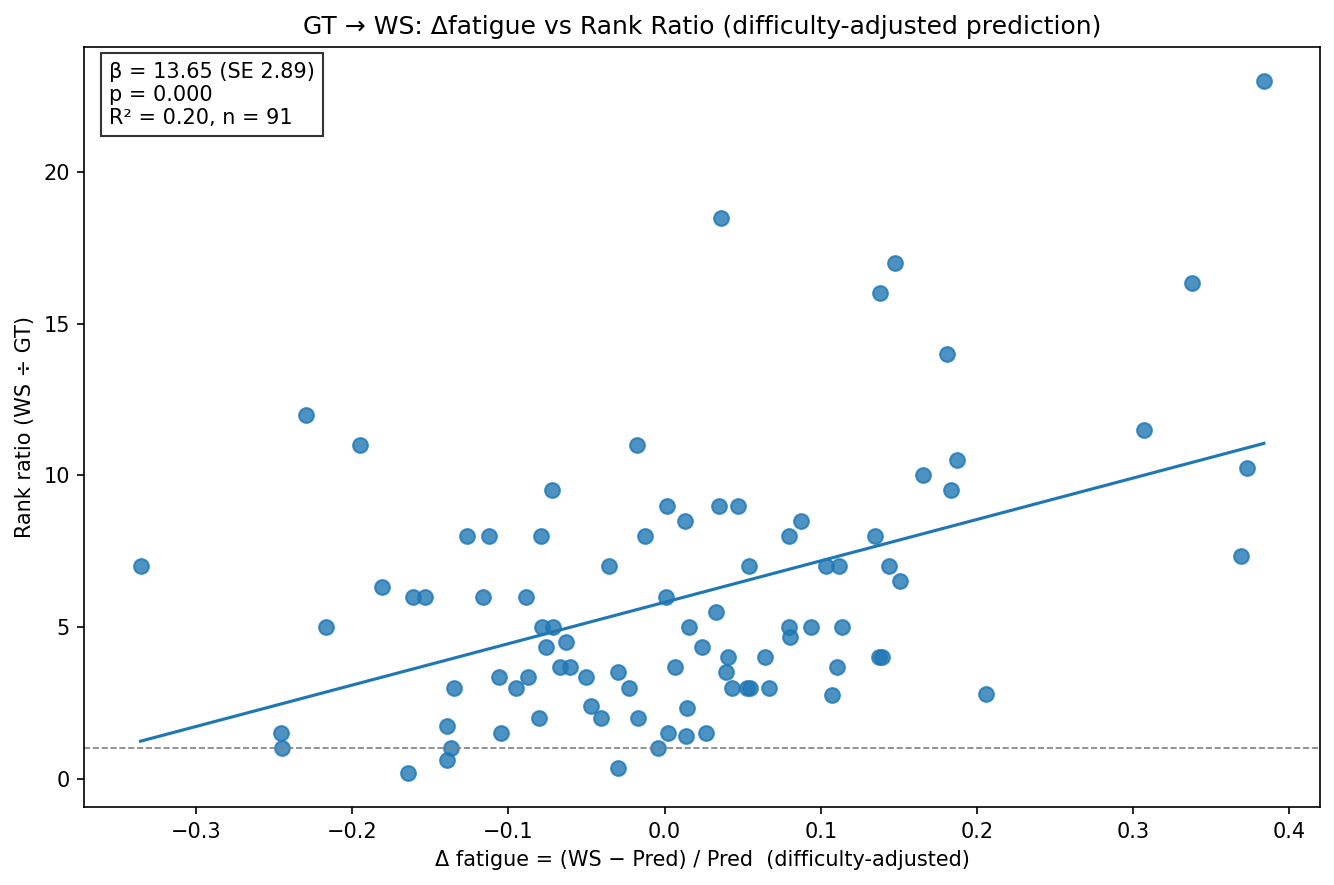

                  coef  std_err        t  p>|t|
const           5.8135   0.4034  14.4120    0.0
delta_fatigue  13.6510   2.8914   4.7213    0.0


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# -------------------------------------------------------------------
# 1) Load the new uploaded CSV dataset
# -------------------------------------------------------------------
file_path = r"C:\Users\user\workspace\c11\Capstone\NewForce-Data-Analytics-Capstone\data\sql_backup_queries_csv\csv\gt_ws_perf_to_HA.csv"
df = pd.read_csv(file_path)

# -------------------------------------------------------------------
# 2) Clean and create time-in-seconds
# -------------------------------------------------------------------
df["gt_gender_rank"] = pd.to_numeric(df["gt_gender_rank"], errors="coerce")
df["ws_gender_rank"] = pd.to_numeric(df["ws_gender_rank"], errors="coerce")

def to_seconds(t):
    try:
        h, m, s = str(t).split(":")
        return int(h) * 3600 + int(m) * 60 + int(float(s))
    except Exception:
        return np.nan

df["gt_sec"] = df["gt_time"].apply(to_seconds)
df["ws_sec"] = df["ws_time"].apply(to_seconds)

# -------------------------------------------------------------------
# 3) Distances (km) map for GT races + WS distance
# -------------------------------------------------------------------
distance_map = {
    "Nice Cote d Azur": 111.0,
    "Chianti (UTCC)": 103.0,
    "The Canyons": 100.0,
    "Black Canyon": 101.0,
    "Javelina": 159.2,
    "Grindstone": 100.0,
    "UTMB": 174.0,
    "CCC": 100.0,
    "Tarawera": 102.0,
    "Bandera": 100.0,
    "Doi Inthanon": 160.0,
    "Festival Des Templiers": 80.6
}
df["gt_distance_km"] = df["gt_race_name"].map(distance_map)
df["ws_distance_km"] = 160.9
df = df.dropna(subset=["gt_distance_km"])

# -------------------------------------------------------------------
# 4) Estimate gender-specific Riegel exponents (k) controlling for difficulty
#    and store full params (const, k, beta_diff) per gender
# -------------------------------------------------------------------
params_by_gender = {}
for g in ['M','F']:
    sub = df[df['gt_gender']==g].dropna(subset=['gt_sec','ws_sec','gt_distance_km','diff_index'])
    sub['log_ratio'] = np.log(sub['ws_sec']/sub['gt_sec'])
    sub['log_dist_ratio'] = np.log(160.9/sub['gt_distance_km'])
    X = sm.add_constant(sub[['log_dist_ratio','diff_index']])
    y = sub['log_ratio']
    res = sm.OLS(y, X).fit()
    params_by_gender[g] = {
        'alpha': res.params['const'],
        'k': res.params['log_dist_ratio'],
        'beta_diff': res.params['diff_index']
    }
    print(f"{g}: k={res.params['log_dist_ratio']:.3f}, beta_diff={res.params['diff_index']:.4f}, alpha={res.params['const']:.4f}, R^2={res.rsquared:.2f}")

# -------------------------------------------------------------------
# 5) Difficulty-adjusted WS prediction and key metrics (NO double-counting later)
# -------------------------------------------------------------------
def predict_ws_time_diffadj(row):
    p = params_by_gender.get(row['gt_gender'])
    if p is None or pd.isna(row['gt_distance_km']) or pd.isna(row['diff_index']) or pd.isna(row['gt_sec']):
        return np.nan
    log_dist = np.log(row['ws_distance_km'] / row['gt_distance_km'])
    log_ratio = p['alpha'] + p['k']*log_dist + p['beta_diff']*row['diff_index']
    ratio = np.exp(log_ratio)
    return row['gt_sec'] * ratio

df['ws_pred_sec'] = df.apply(predict_ws_time_diffadj, axis=1)  # difficulty-adjusted prediction
df['delta_fatigue'] = (df['ws_sec'] - df['ws_pred_sec']) / df['ws_pred_sec']
df['rank_ratio'] = df['ws_gender_rank'] / df['gt_gender_rank']

# Build valid modeling set
valid = df.dropna(subset=['delta_fatigue','rank_ratio'])

# -------------------------------------------------------------------
# 6) OLS with ONLY delta_fatigue (difficulty already used inside ws_pred_sec)
# -------------------------------------------------------------------
X = sm.add_constant(valid[['delta_fatigue']])
y = valid['rank_ratio']
model = sm.OLS(y, X).fit()

# -------------------------------------------------------------------
# 7) Simple scatter with fit (no partials needed since single predictor)
# -------------------------------------------------------------------
m, b = np.polyfit(valid['delta_fatigue'], valid['rank_ratio'], 1)
x_line = np.linspace(valid['delta_fatigue'].min(), valid['delta_fatigue'].max(), 200)
y_line = m * x_line + b

plt.figure(figsize=(9, 6), dpi=150)
plt.scatter(valid['delta_fatigue'], valid['rank_ratio'], s=50, alpha=0.8)
plt.plot(x_line, y_line, linewidth=1.5)
plt.axhline(1.0, linestyle="--", linewidth=0.8, color="gray")  # rank_ratio = 1 reference
plt.xlabel("Δ fatigue = (WS − Pred) / Pred  (difficulty-adjusted)")
plt.ylabel("Rank ratio (WS ÷ GT)")
plt.title("GT → WS: Δfatigue vs Rank Ratio (difficulty-adjusted prediction)")

beta = model.params['delta_fatigue']
se = model.bse['delta_fatigue']
p = model.pvalues['delta_fatigue']
r2 = model.rsquared
n = int(valid.shape[0])
p_display = f"{p:.3f}" if p >= 0.001 else "0.000"
text = f"β = {beta:.2f} (SE {se:.2f})\np = {p_display}\nR² = {r2:.2f}, n = {n}"
plt.text(0.02, 0.98, text, transform=plt.gca().transAxes,
         ha="left", va="top",
         bbox=dict(facecolor="white", alpha=0.8))
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 8) Coefficient table
# -------------------------------------------------------------------
coef_table = pd.DataFrame({
    "coef": model.params,
    "std_err": model.bse,
    "t": model.tvalues,
    "p>|t|": model.pvalues
}).round(4)
print(coef_table)


In [86]:
df = pd.read_csv('../../data/master/excel_workbooks/gt_ws_perf_for_power_bi.csv')

In [87]:
import pandas as pd
import numpy as np

df['gt_year'] = pd.to_datetime(df['gt_race_date'], errors='coerce').dt.year

# 1) Parse mm:ss → seconds
m_s = df['gt_pace'].str.split(':', expand=True).astype(float)
df['gt_sec'] = m_s[0]*60 + m_s[1]

# 2) Group & average (include gt_race_class if you want to use it)
out = (
    df.groupby(['gt_gender', 'gt_race_class', 'gt_race_name', 'gt_year'], dropna=False)['gt_sec']
      .mean()
      .round()
      .astype('Int64')
      .reset_index(name='avg_sec')
)

# 3) Format back to mm:ss
mm = (out['avg_sec'] // 60).astype(int)
ss = (out['avg_sec'] % 60).astype(int)
out['avg_gt_pace'] = mm.astype(str).str.zfill(2) + ':' + ss.astype(str).str.zfill(2)

# 4) Rename + keep nice columns
out = out.rename(columns={
    'gt_gender': 'Gender',
    'gt_race_class': 'Race Class',
    'gt_race_name': 'Race',
    'gt_year': 'Year',
    'avg_gt_pace': 'Avg GT Pace (mm:ss)'
})[['Gender', 'Race Class', 'Race', 'Year', 'Avg GT Pace (mm:ss)']]

out.head()

,Gender,Race Class,Race,Year,Avg GT Pace (mm:ss)
0,F,100K,Bandera,2022,09:09
1,F,100K,Bandera,2023,09:08
2,F,100K,Black Canyon,2022,09:00
3,F,100K,Black Canyon,2023,08:25
4,F,100K,Black Canyon,2024,08:31


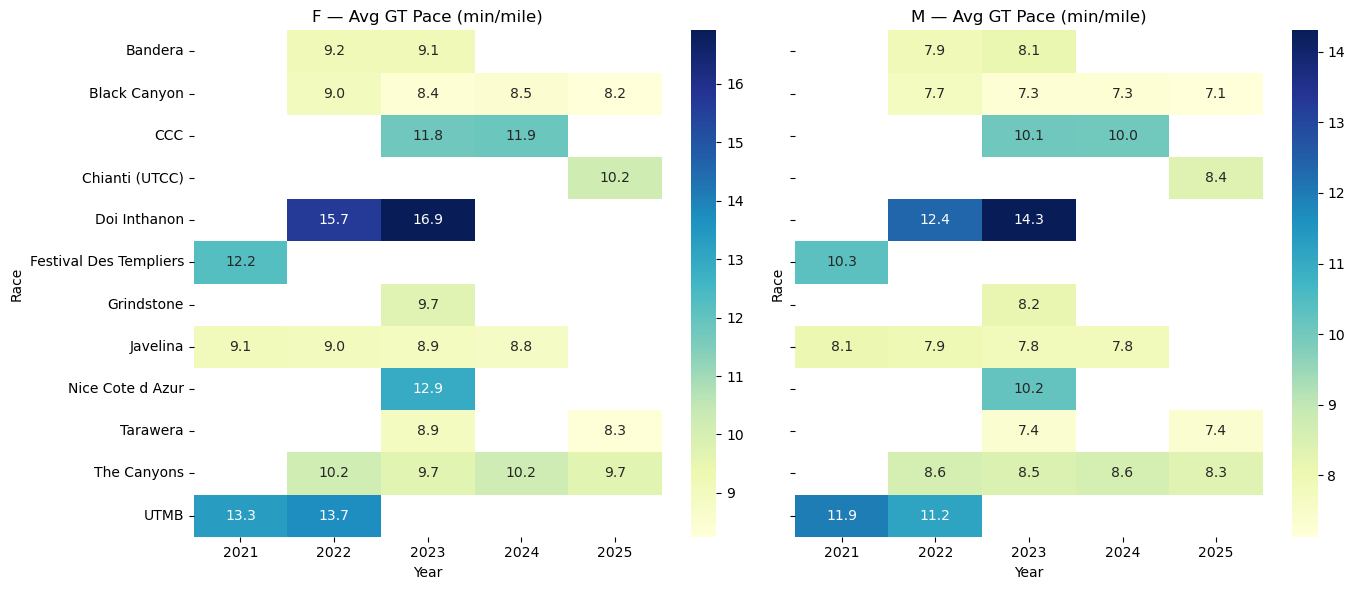

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Convert mm:ss → numeric minutes ---
def pace_to_minutes(p):
    m, s = p.split(':')
    return int(m) + int(s)/60

out['pace_minutes'] = out['Avg GT Pace (mm:ss)'].apply(pace_to_minutes)

# --- Set up subplots, one per gender ---
genders = out['Gender'].unique()
fig, axes = plt.subplots(1, len(genders), figsize=(14, 6), sharey=True)

if len(genders) == 1:
    axes = [axes]  # handle case of only one gender

for ax, gender in zip(axes, genders):
    subset = out[out['Gender'] == gender]
    pivot = subset.pivot_table(index='Race', columns='Year', values='pace_minutes', aggfunc='mean')
    
    sns.heatmap(
        pivot, annot=True, fmt=".1f", cmap="YlGnBu", cbar=True, ax=ax
    )
    ax.set_title(f"{gender} — Avg GT Pace (min/mile)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Race")

plt.tight_layout()
plt.show()

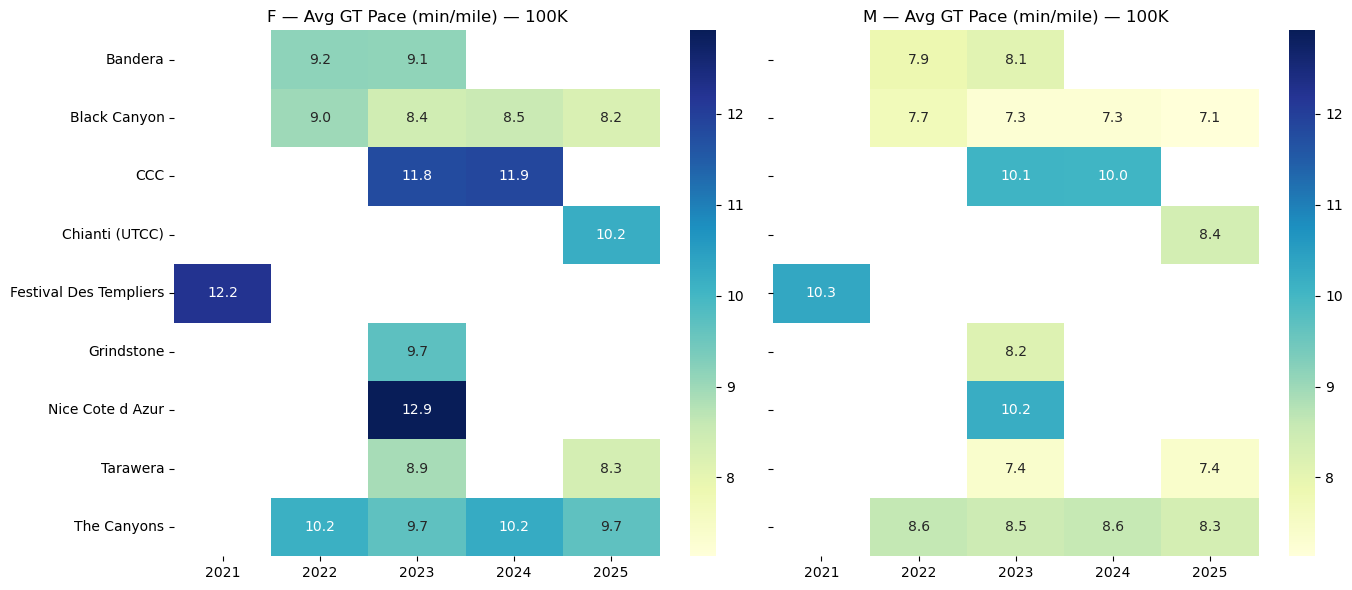

In [90]:
# ---- pick the class column (supports either name) ----
class_col = 'Race Class' if 'Race Class' in out.columns else (
    'gt_race_class' if 'gt_race_class' in out.columns else None
)
if class_col is None:
    raise ValueError("No race-class column found. Add 'gt_race_class' (or rename to 'Race Class').")

# ---- filter to 100K only
out_100k = out[out[class_col].astype(str).str.strip().str.lower().eq('100k')].copy()

# --- Convert mm:ss → numeric minutes
def pace_to_minutes(p):
    m, s = p.split(':')
    return int(m) + int(s)/60

out_100k['pace_minutes'] = out_100k['Avg GT Pace (mm:ss)'].apply(pace_to_minutes)

# (optional) shared color scale across panels for fair comparison
vmin = np.nanmin(out_100k['pace_minutes'])
vmax = np.nanmax(out_100k['pace_minutes'])

# --- Set up subplots, one per gender ---
genders = out_100k['Gender'].dropna().unique()
fig, axes = plt.subplots(1, len(genders), figsize=(14, 6), sharey=True)
if len(genders) == 1:
    axes = [axes]

for ax, gender in zip(axes, genders):
    subset = out_100k[out_100k['Gender'] == gender]
    pivot = subset.pivot_table(index='Race', columns='Year', values='pace_minutes', aggfunc='mean')

    sns.heatmap(
        pivot, annot=True, fmt=".1f", cmap="YlGnBu", cbar=True, ax=ax,
        vmin=vmin, vmax=vmax   # keep scales comparable across genders
    )
    ax.set_title(f"{gender} — Avg GT Pace (min/mile) — 100K")
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

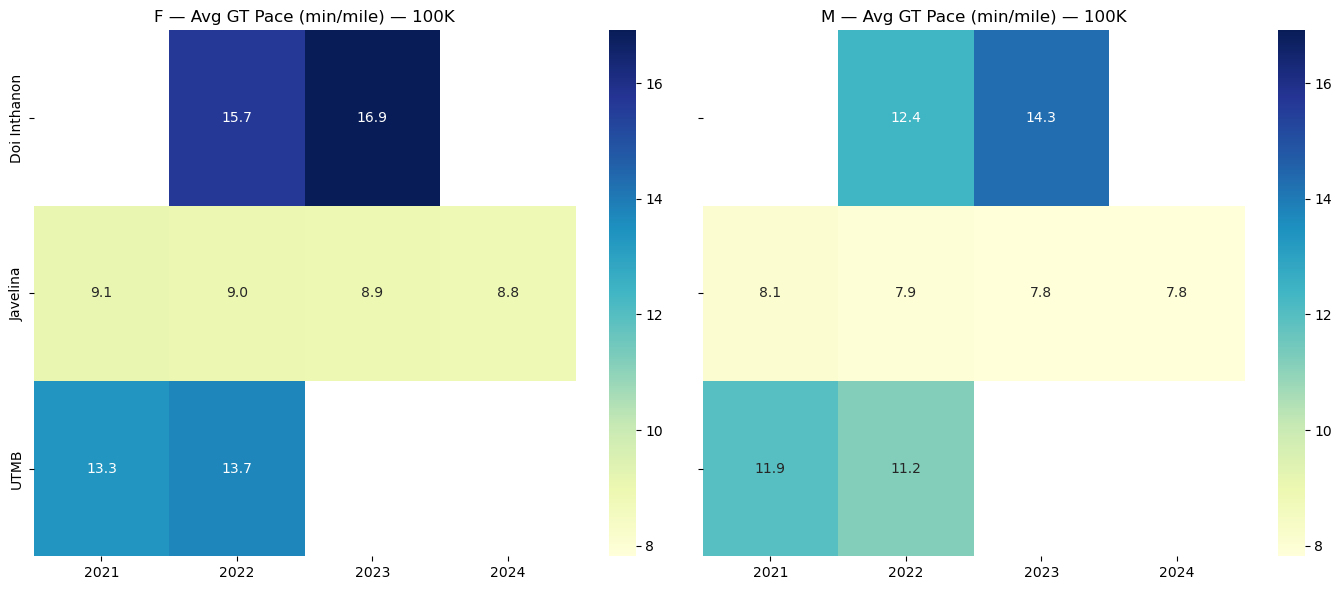

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---- pick the class column (supports either name) ----
class_col = 'Race Class' if 'Race Class' in out.columns else (
    'gt_race_class' if 'gt_race_class' in out.columns else None
)
if class_col is None:
    raise ValueError("No race-class column found. Add 'gt_race_class' (or rename to 'Race Class').")

# ---- filter to 100m only
out_100m = out[out[class_col].astype(str).str.strip().str.lower().eq('100m')].copy()

# --- Convert mm:ss → numeric minutes
def pace_to_minutes(p):
    m, s = p.split(':')
    return int(m) + int(s)/60

out_100m['pace_minutes'] = out_100m['Avg GT Pace (mm:ss)'].apply(pace_to_minutes)

# (optional) shared color scale across panels for fair comparison
vmin = np.nanmin(out_100m['pace_minutes'])
vmax = np.nanmax(out_100m['pace_minutes'])

# --- Set up subplots, one per gender ---
genders = out_100m['Gender'].dropna().unique()
fig, axes = plt.subplots(1, len(genders), figsize=(14, 6), sharey=True)
if len(genders) == 1:
    axes = [axes]

for ax, gender in zip(axes, genders):
    subset = out_100m[out_100m['Gender'] == gender]
    pivot = subset.pivot_table(index='Race', columns='Year', values='pace_minutes', aggfunc='mean')

    sns.heatmap(
        pivot, annot=True, fmt=".1f", cmap="YlGnBu", cbar=True, ax=ax,
        vmin=vmin, vmax=vmax   # keep scales comparable across genders
    )
    ax.set_title(f"{gender} — Avg GT Pace (min/mile) — 100K")
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

In [95]:
import pandas as pd

# Load your uploaded dataset
df = pd.read_csv('../../data/master/excel_workbooks/gt_ws_perf_for_power_bi.csv')

# --- Clean and check columns ---
# Ensure we have the right columns present
cols_needed = ['gt_gender', 'age_category', 'ws_gender_rank']
missing = [c for c in cols_needed if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Convert rank to numeric if stored as text
df['ws_gender_rank'] = pd.to_numeric(df['ws_gender_rank'], errors='coerce')

# --- Group and aggregate ---
summary = (
    df.groupby(['gt_gender', 'age_category'])
      .agg(
          avg_rank=('ws_gender_rank', 'mean'),
          median_rank=('ws_gender_rank', 'median'),
          count=('ws_gender_rank', 'count')
      )
      .reset_index()
      .sort_values(['gt_gender', 'age_category'])
)

# Round for cleaner display
summary['avg_rank'] = summary['avg_rank'].round(0)
summary['median_rank'] = summary['median_rank'].round(0)

# Optional: rename for presentation
summary = summary.rename(columns={
    'gt_gender': 'Gender',
    'age_category': 'Age Category',
    'avg_rank': 'Avg WS Gender Rank',
    'median_rank': 'Median WS Gender Rank',
    'count': 'N'
})

# Display result
summary

,Gender,Age Category,Count,avg_ws_time_hh:mm:ss,avg_ws_hours
0,F,20-34,0,,NaN
1,F,35-39,0,,NaN
2,F,40-44,0,,NaN
3,F,45-49,0,,NaN
4,M,20-34,0,,NaN
5,M,35-39,0,,NaN
6,M,40-44,0,,NaN
7,M,45-49,0,,NaN


In [98]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('../../data/master/excel_workbooks/gt_ws_perf_for_power_bi.csv')

# Ensure required columns exist
for c in ['gt_gender', 'age_category', 'ws_time']:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

# --- Convert fractional days → total seconds ---
df['ws_seconds'] = pd.to_numeric(df['ws_time'], errors='coerce') * 24 * 3600

# Drop missing
df_valid = df.dropna(subset=['ws_seconds', 'gt_gender', 'age_category'])

# --- Group by gender and age category ---
summary = (
    df_valid.groupby(['gt_gender', 'age_category'], dropna=False)['ws_seconds']
           .mean()
           .reset_index(name='avg_ws_seconds')
)

# --- Convert to hours and hh:mm:ss ---
summary['avg_ws_hours'] = (summary['avg_ws_seconds'] / 3600).round(2)
summary['avg_ws_hh:mm:ss'] = summary['avg_ws_seconds'].apply(
    lambda s: f"{int(s//3600):02d}:{int((s%3600)//60):02d}:{int(s%60):02d}"
)

# --- Clean up ---
summary = summary.rename(columns={
    'gt_gender': 'Gender',
    'age_category': 'Age Category'
})[['Gender', 'Age Category', 'avg_ws_hh:mm:ss']]

summary

,Gender,Age Category,avg_ws_hh:mm:ss
0,F,20-34,19:13:13
1,F,35-39,18:01:16
2,F,40-44,19:43:21
3,F,45-49,20:37:07
4,M,20-34,16:38:48
5,M,35-39,16:25:57
6,M,40-44,16:35:23
7,M,45-49,16:20:02


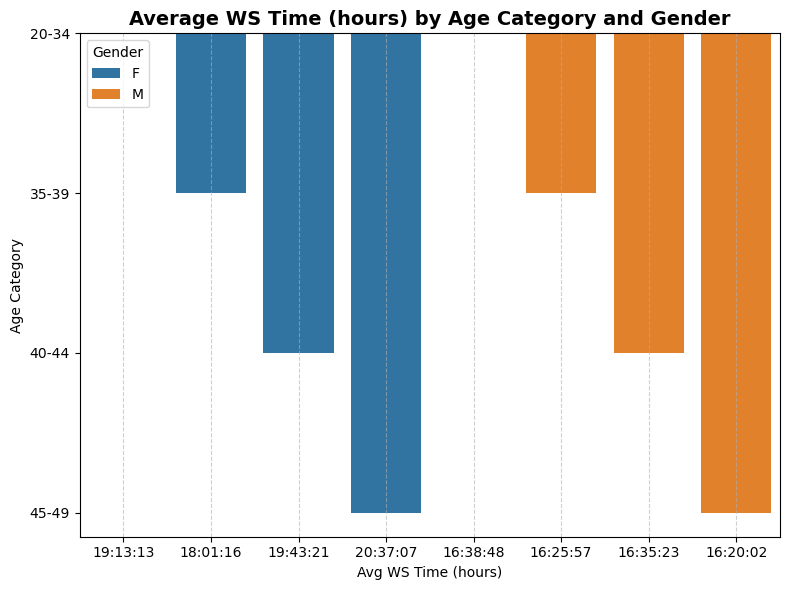

In [103]:
plt.figure(figsize=(8,6))
sns.barplot(
    data=summary,
    y='Age Category',
    x='avg_ws_hh:mm:ss',
    hue = 'Gender'
)
plt.title("Average WS Time (hours) by Age Category and Gender", fontsize=14, fontweight='bold')
plt.xlabel("Avg WS Time (hours)")
plt.ylabel("Age Category")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

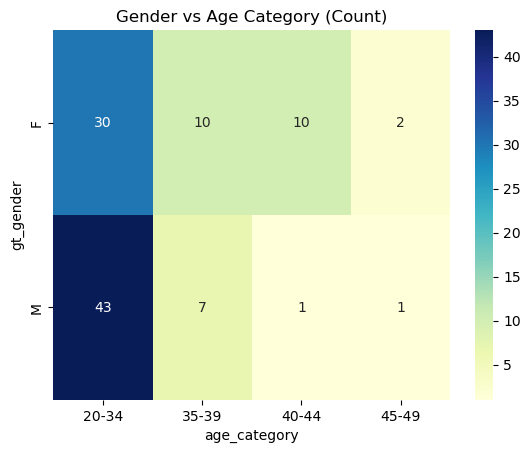

In [106]:
import seaborn as sns
ct = pd.crosstab(df['gt_gender'], df['age_category'])
sns.heatmap(ct, annot=True, cmap='YlGnBu')
plt.title('Gender vs Age Category (Count)')
plt.show()

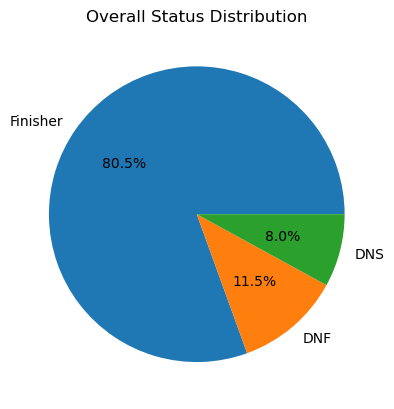

In [111]:
df['ws_status'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    title='Overall Status Distribution', 
    ylabel=''
)
plt.show()

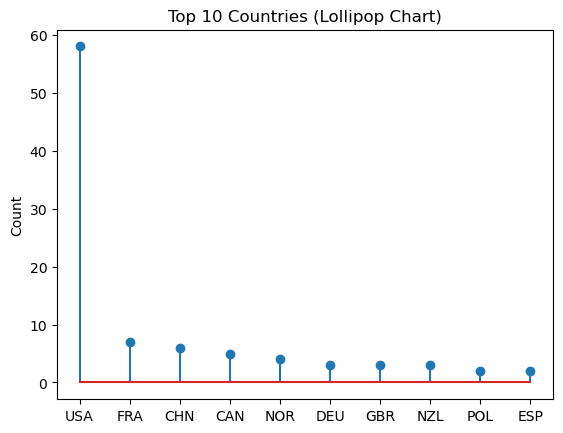

C:\Users\user\AppData\Local\Temp\ipykernel_25308\2823646990.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



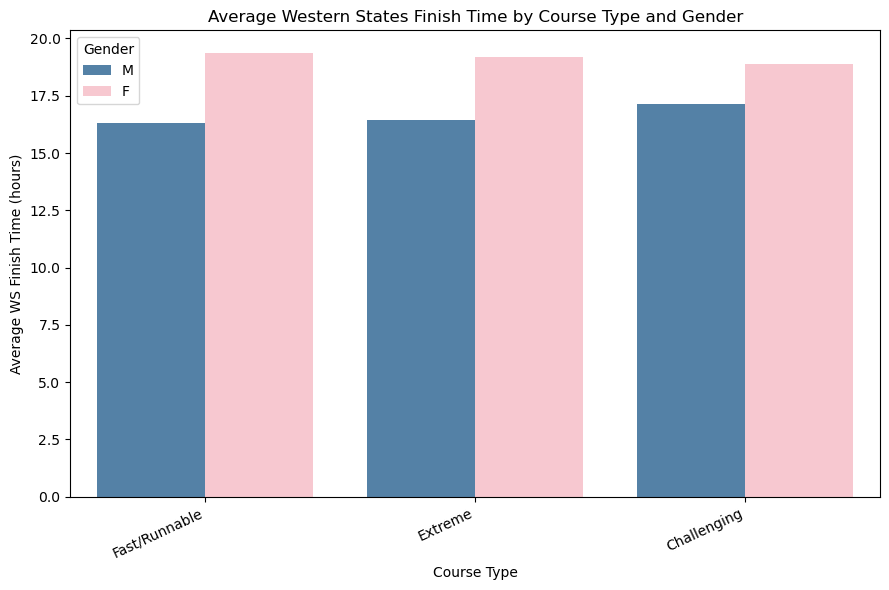

In [124]:


# Mapping from race name to course type
course_map = {
    'Black Canyon': 'Fast/Runnable',
    'Festival Des Templiers': 'Challenging',
    'Javelina': 'Fast/Runnable',
    'Bandera': 'Fast/Runnable',
    'The Canyons': 'Challenging',
    'Grindstone': 'Challenging',
    'Festival Des Templiers': 'Challenging',
    'UTMB': 'Extreme',
    'CCC': 'Challenging',
    'Nice Cote d Azur': 'Fast/Runnable',
    'Chianti (UTCC)': 'Fast/Runnable',
    'Tarawera': 'Fast/Runnable',
    'Doi Inthanon': 'Extreme'
}

# Ensure race name and gender columns exist
col_race = "gt_race_name" if "gt_race_name" in df.columns else "race_name"
col_gender = "gt_gender" if "gt_gender" in df.columns else "gender"

# Map course type
df["course_type"] = df[col_race].map(course_map)

# Filter valid finishers with WS times
df_valid = df[(df["ws_status"] == "Finisher") & (df["ws_time"].notna()) & (df["course_type"].notna())]

# Convert WS time fraction of a day → hours
df_valid["ws_time_hours"] = pd.to_numeric(df_valid["ws_time"], errors="coerce") * 24

# Compute average WS finish time by course type and gender
avg_time = (
    df_valid.groupby(["course_type", col_gender])["ws_time_hours"]
    .mean()
    .reset_index()
    .sort_values("ws_time_hours")
)

# -----------------------------
# Plot grouped bar chart
# -----------------------------
plt.figure(figsize=(9, 6))
sns.barplot(data=avg_time, x="course_type", y="ws_time_hours", hue=col_gender, palette={"F": "pink", "M": "steelblue"})
plt.title("Average Western States Finish Time by Course Type and Gender")
plt.ylabel("Average WS Finish Time (hours)")
plt.xlabel("Course Type")
plt.xticks(rotation=25, ha="right")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()


In [118]:
course_map = {
    'Black Canyon': 'Fast/Runnable Desert',
    'Javelina': 'Fast/Runnable Desert',
    'Bandera': 'Fast/Runnable Desert',
    'The Canyons': 'California/WS-Style',
    'Grindstone': 'California/WS-Style',
    'Festival Des Templiers': 'California/WS-Style',
    'UTMB': 'Technical/Alpine Europe',
    'CCC': 'Technical/Alpine Europe',
    'Nice Cote d Azur': 'Technical/Alpine Europe',
    'Chianti (UTCC)': 'Technical/Alpine Europe',
    'Tarawera': 'Humid/Tropical Mountain',
    'Doi Inthanon': 'Humid/Tropical Mountain'
}
df["course_type"] = df[col_race].map(course_map)

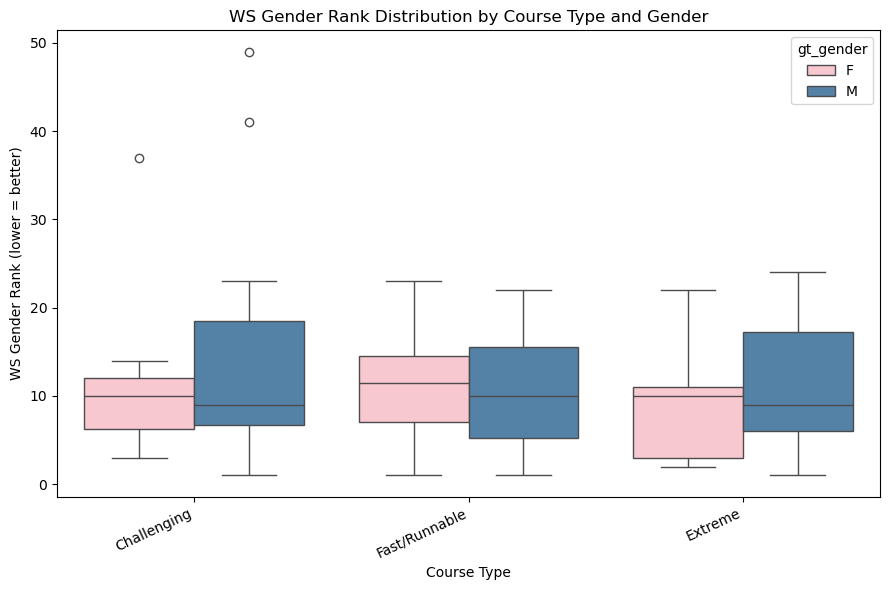

In [125]:
plt.figure(figsize=(9,6))
sns.boxplot(
    data=df_valid, 
    x="course_type", 
    y="ws_gender_rank", 
    hue=col_gender, 
    palette={"F":"pink","M":"steelblue"}
)
plt.title("WS Gender Rank Distribution by Course Type and Gender")
plt.ylabel("WS Gender Rank (lower = better)")
plt.xlabel("Course Type")
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()